
# Gaussian Mixture Model Sine Curve

This example demonstrates the behavior of Gaussian mixture models fit on data
that was not sampled from a mixture of Gaussian random variables. The dataset
is formed by 100 points loosely spaced following a noisy sine curve. There is
therefore no ground truth value for the number of Gaussian components.

The first model is a classical Gaussian Mixture Model with 10 components fit
with the Expectation-Maximization algorithm.

The second model is a Bayesian Gaussian Mixture Model with a Dirichlet process
prior fit with variational inference. The low value of the concentration prior
makes the model favor a lower number of active components. This models
"decides" to focus its modeling power on the big picture of the structure of
the dataset: groups of points with alternating directions modeled by
non-diagonal covariance matrices. Those alternating directions roughly capture
the alternating nature of the original sine signal.

The third model is also a Bayesian Gaussian mixture model with a Dirichlet
process prior but this time the value of the concentration prior is higher
giving the model more liberty to model the fine-grained structure of the data.
The result is a mixture with a larger number of active components that is
similar to the first model where we arbitrarily decided to fix the number of
components to 10.

Which model is the best is a matter of subjective judgment: do we want to
favor models that only capture the big picture to summarize and explain most of
the structure of the data while ignoring the details or do we prefer models
that closely follow the high density regions of the signal?

The last two panels show how we can sample from the last two models. The
resulting samples distributions do not look exactly like the original data
distribution. The difference primarily stems from the approximation error we
made by using a model that assumes that the data was generated by a finite
number of Gaussian components instead of a continuous noisy sine curve.


In [32]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import mixture

import sys
sys.path.append('/home/vbwanere/OneDrive/GitHub_repos/GitHub_repos_python/seds_in_jax/gmm_lib')
from gaussian_mixture import GaussianMixture

In [34]:
# Generating a sine wave datset for GMR:
n_samples = 1000

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4.0 * np.pi / X.shape[0]

for i in range(X.shape[0]):
    x = i * step - 6.0
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3.0 * (np.sin(x) + np.random.normal(0, 0.2))

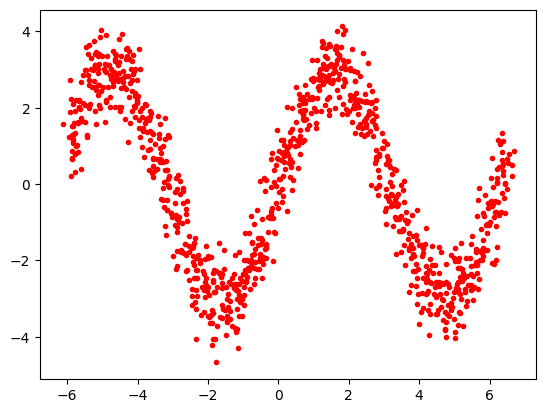

In [41]:
plt.scatter(X[:, 0], X[:, 1], color ='red', marker='.')

In [33]:
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [20]:
# Fit a Gaussian Mixture Model:
gmm = GaussianMixture(k=8, max_iter=350)
gmm.fit(X)

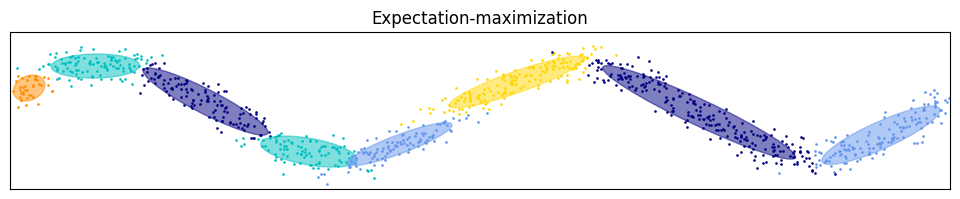

In [29]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.04, top=0.95, hspace=0.2, wspace=0.05,\
    left=0.03, right=0.97)
plot_results(X, gmm.predict(X), gmm.means, gmm.covariances, 0, "Expectation-maximization")

In [66]:
# Use `scikit-learn GaussianMixture libraray:
gmm = mixture.GaussianMixture(n_components=10, covariance_type="full",\
    max_iter=100).fit(X)

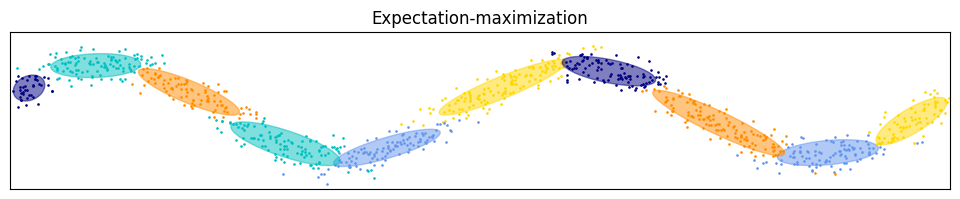

In [88]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.04, top=0.95, hspace=0.2, wspace=0.05,\
    left=0.03, right=0.97)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_,\
    0, "Expectation-maximization")

In [94]:
def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [85]:
dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="random",
    max_iter=186,
    random_state=2,
).fit(X)

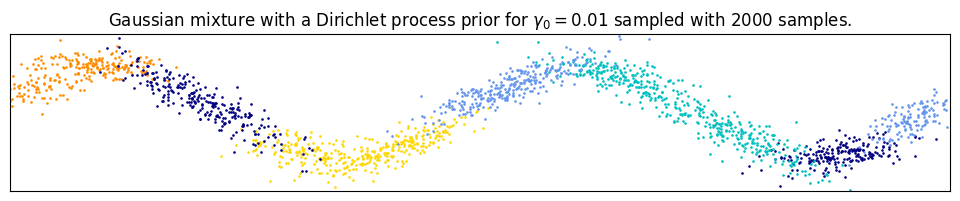

In [97]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.04, top=0.95, hspace=0.2, wspace=0.05,\
    left=0.03, right=0.97)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    0,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=0.01$ sampled with $2000$ samples.",
)

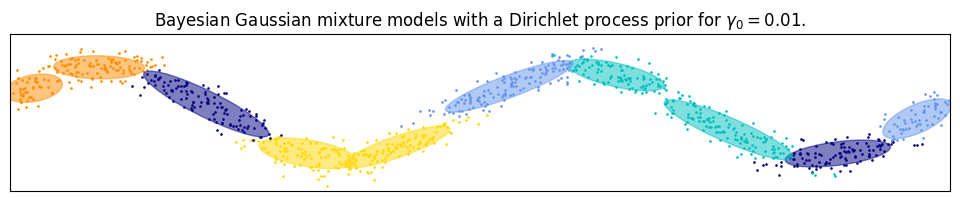

In [95]:
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=0.01$.",
)

In [98]:
dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="kmeans",
    max_iter=100,
    random_state=2,
).fit(X)

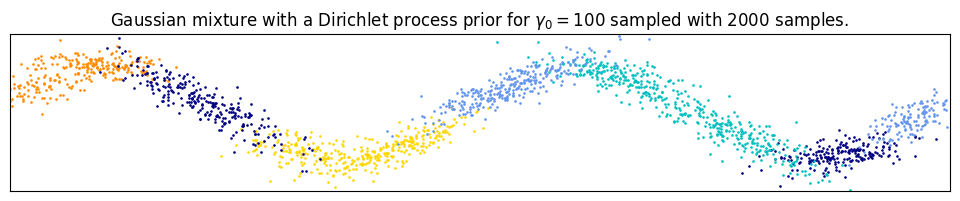

In [99]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.04, top=0.95, hspace=0.2, wspace=0.05,\
    left=0.03, right=0.97)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    1,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=100$ sampled with $2000$ samples.",
)

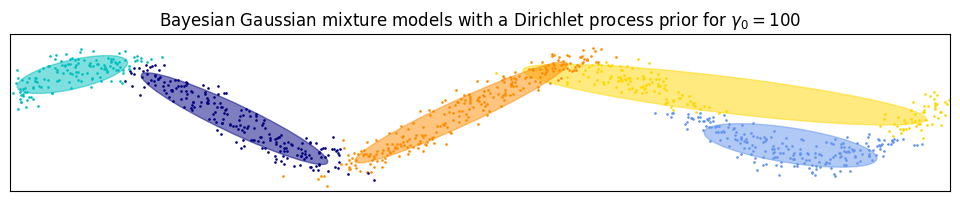

In [89]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=0.04, top=0.95, hspace=0.2, wspace=0.05,\
    left=0.03, right=0.97)

plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    2,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=100$",
)